In [1]:
import numpy as np
import torch
from mcspace.data_utils import get_data, get_mouse_diet_perturbations_dataset, get_human_timeseries_dataset
from mcspace.utils import get_device, pickle_load, pickle_save, get_summary_results, MODEL_FILE, DATA_FILE
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from mcspace.dataset import DataSet
import pandas as pd
import ete3
from Bio import SeqIO, Phylo

import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import scipy.cluster.hierarchy as sch

In [2]:
# change font
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"

# Paths

In [3]:
basepath = Path("./")
rootpath = Path("../../")
datapath = rootpath / "paper" / "datasets"

outpath = basepath / "main_figures"
outpath.mkdir(exist_ok=True, parents=True)

In [4]:
treepath = datapath / "human_experiments" / "human_otus_tree" / "output"
treefile = "newick_tree_query_reads.nhx"

# Load human dataset

In [5]:
reads, num_otus, times, subjects, dataset = get_human_timeseries_dataset(rootpath=datapath)

human_times = times
human_subjects = subjects

c:\users\gary\partners healthcare dropbox\gurdip uppal\research_bwh\mcspace_final\mcspace\mcspace\dataset.py:21: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  self._long_data = pd.read_csv(reads)


### get taxonomy

In [6]:
temp_taxonomy = dataset.get_taxonomy() 
# updated taxonomy
humanpath = datapath / "human_experiments"
humantax = pd.read_csv(humanpath / "gappa_taxonomy" / "human_taxonomy.csv", index_col=0)
taxonomy = humantax.loc[temp_taxonomy.index,:]

## plot particle data

In [7]:
reads

{1: {'H11': array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,  87., 292.,   0.],
         [  0.,   0.,   0., ...,   0.,  86.,   0.],
         ...,
         [  0.,   0.,   0., ...,   0., 515.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.]])},
 2: {'H11': array([[  0.,   0.,   0., ...,   0., 361.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   1.,   0.],
         ...,
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.]])},
 3: {'H11': array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
          0.000e+00],
         [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 1.180e+02,
          1.000e+00],
         [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 1.950e+02,
          0.000e+00],
         ...,
         [0.000e+00, 0

In [8]:
def pool_subjects(reads,times,subjects):
    pooled_data = {}
    for t in times:
        all_particles = None
        for s in subjects:
            if all_particles is None:
                all_particles = reads[t][s]
            else:
                all_particles = np.concatenate([all_particles, reads[t][s]], axis=0)
        pooled_data[t] = all_particles
    return pooled_data



def get_pruned_tree(treepath, treefile, taxonomy, temppath=Path("./_tmp"), upper=False):
    tree = ete3.Tree((treepath / treefile).as_posix())
    print("original tree size:", len(tree))
    taxaids = list(taxonomy.index)
    if upper:
        taxaids = [idx.upper() for idx in taxaids]
    tree.prune(taxaids, True)
    print("pruned tree size:", len(tree))
    
    treeout = "tree.nhx"
    temppath.mkdir(exist_ok=True, parents=True)
    tree.write(outfile=(temppath / treeout).as_posix())
    phylo_tree = Phylo.read(temppath / treeout, format='newick')
    return phylo_tree


def get_lowest_level(otu, taxonomy):
    taxonomies = ['Species','Genus', 'Family', 'Order', 'Class', 'Phylum', 'Kingdom']
    for level in taxonomies:
        levelid = taxonomy.loc[otu,level]
        if levelid != 'na':
            return levelid, level
        

def plot_phylo_tree(ax, tree, taxonomy, fontsize=16, text_len=41):            
    TEXT_LEN=text_len
    prefix_taxa = {'Species': '*', 'Genus': '**', 'Family': '***', 'Order': '****',
                   'Class': '*****', 'Phylum': '******', 'Kingdom': '*******'}

    Phylo.draw(tree, axes=ax, do_show=False, show_confidence=False)
    taxa_order = []

    for text in ax.texts:
        taxonname = str(text._text).replace(' ','').capitalize()
        otu_name = taxonname
        taxa_order.append(otu_name)
        name, level = get_lowest_level(otu_name, taxonomy)
        prefix = prefix_taxa[level]
        taxonname = ' ' + prefix + ' ' + name + ' ' + otu_name.upper()
        text._text = taxonname
        text._text = text._text + '- ' * (TEXT_LEN - len(text._text))
        text.set_fontsize(fontsize)
        if (level == 'Species') or (level == 'Genus') or (level == 'Family'):
            text.set_fontstyle('italic')
    ax = remove_border(ax)
    return ax, taxa_order


def add_border(ax, color='black'):
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1.0)
        spine.set_color(color)
    return ax


def remove_border(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.xaxis.set_minor_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_minor_locator(plt.NullLocator())
    ax.set_xlabel('')
    ax.set_ylabel('')
    return ax

In [9]:
humanreads = pool_subjects(reads, times, subjects)

In [10]:
# humanreads

In [11]:
humanreads[times[0]].shape # LxO

(1419, 58)

In [12]:
t = times[0]

In [13]:
vmin=-3
vmax=0
cmap = plt.get_cmap('Greys')
cmap.set_under('white')
#mcolors.LinearSegmentedColormap.from_list('cmap', 
#                                              [(0,    'white'),
#                                               (0.5, 'yellowgreen'),
#                                               (1,    'darkred')], N=256)

In [14]:
# counts = humanreads[t]
# ra = counts/(counts.sum(axis=1,keepdims=True))
# logra = np.log10(ra + 1e-10)
# # cluster particles
# data_matrix=logra.T
# col_dist = sch.linkage(data_matrix.T, method='ward')
# col_order = sch.leaves_list(col_dist)
# ordered_data_matrix = data_matrix[:, col_order]

# fig, ax = plt.subplots()
# ax=sns.heatmap(ordered_data_matrix, cmap=cmap, vmin=vmin,vmax=vmax,cbar=False,ax=ax, 
#                xticklabels=False, yticklabels=True)
# # ax.set_xticklabels("")
# ax.set_yticklabels("")
# ax=add_border(ax)

# # fig, ax2 = plt.subplots(figsize=(3,1))
# # norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
# # ax2=mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='horizontal')


In [33]:
width_ratios = [1,1]
for t in times:
    width_ratios.append(humanreads[t].shape[0]/2200)

original tree size: 3923
pruned tree size: 58


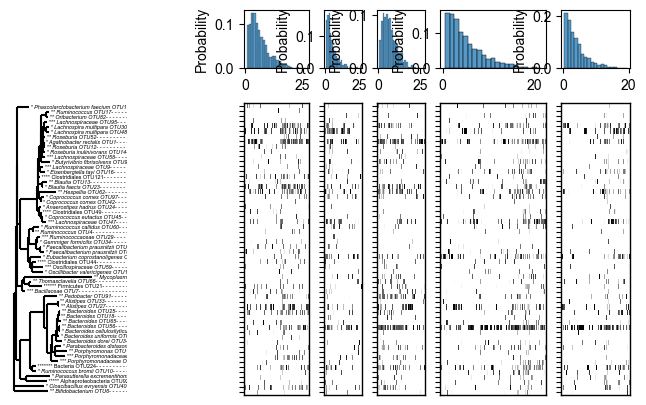

In [34]:
fig, ax = plt.subplots(figsize=(8,5),ncols=len(times)+2, nrows=2, height_ratios=[1,5], width_ratios=width_ratios)
tree_fontsize = 4

ax_tree = ax[1,0]
# plot tree
taxa = taxonomy.reset_index().copy()
taxa = taxa.set_index("Otu")
taxa_subset = taxa #.loc[otu_sub_z2,:]
tree = get_pruned_tree(treepath, treefile, taxa_subset, temppath=Path("./_tmp_sub"), upper=True)
ax_tree, otu_order = plot_phylo_tree(ax_tree, tree, taxonomy, fontsize=tree_fontsize) #, text_len=tree_text_len)

for ix,t in enumerate(times):
    i = ix+2
    counts = humanreads[t]
    ra = counts/(counts.sum(axis=1,keepdims=True))
    notuspp = (ra>0.005).sum(axis=1)

    logra = np.log10(ra + 1e-10)
    # cluster particles
    data_matrix=logra.T
    col_dist = sch.linkage(data_matrix.T, method='ward')
    col_order = sch.leaves_list(col_dist)
    ordered_data_matrix = data_matrix[:, col_order]

    ax[0,i]=sns.histplot(notuspp, discrete=True, ax=ax[0,i], stat='probability')
    ax[1,i]=sns.heatmap(ordered_data_matrix, cmap=cmap, vmin=vmin,vmax=vmax,cbar=False,ax=ax[1,i], 
                   xticklabels=False, yticklabels=True)
    # ax.set_xticklabels("")
    ax[1,i].set_yticklabels("")
    ax[1,i]=add_border(ax[1,i])



ax[0,0] = remove_border(ax[0,0])
ax[0,1] = remove_border(ax[0,1])
ax[1,1]=remove_border(ax[1,1])

## scale columns by number of particles??; and mouse vs human by number of otus...

### show difference between mouse and human, pool all particles?; test stasitical difference between distributions...


# mouse data

In [35]:
mouse_reads, num_otus, mouse_times, mouse_subjects, mouse_dataset = get_mouse_diet_perturbations_dataset(rootpath=datapath)

c:\users\gary\partners healthcare dropbox\gurdip uppal\research_bwh\mcspace_final\mcspace\mcspace\dataset.py:23: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  self._long_data = pd.read_csv(reads, compression='gzip')


In [36]:
temp_taxonomy = mouse_dataset.get_taxonomy() 
# updated taxonomy
mousepath = datapath / "mouse_experiments"
mousetax = pd.read_csv(mousepath / "taxonomy" / "taxonomy.csv", index_col=0)
mouse_taxonomy = mousetax.loc[temp_taxonomy.index,:]

In [38]:
for t in mouse_times:
    for s in mouse_subjects:
        print(mouse_reads[t][s].shape[0])

3626
2951
2971
2167
3469
3832
2865
2210
2727
324
2150
1730
3774
1355
1977
1370
2829
5010
3995
2687
2829


In [60]:
# fig, ax = plt.subplots(figsize=(8,5),ncols=len(mouse_times))

# for ix,t in enumerate(mouse_times):
#     i = ix#+2
    
#     all_particles = None
#     spos = []
#     sx = 0
#     for s in mouse_subjects:
#         counts = mouse_reads[t][s]
#         spos.append(sx + counts.shape[0])
#         ra = counts/(counts.sum(axis=1,keepdims=True))
#         logra = np.log10(ra + 1e-10)
#         # cluster particles within subjects
#         data_matrix=logra.T
#         col_dist = sch.linkage(data_matrix.T, method='ward')
#         col_order = sch.leaves_list(col_dist)
#         ordered_data_matrix = data_matrix[:, col_order].T
#         if all_particles is None:
#             all_particles = ordered_data_matrix
#         else:
#             all_particles = np.concatenate([all_particles, ordered_data_matrix], axis=0)
#     ax[i]=sns.heatmap(logra, cmap=cmap, vmin=vmin,vmax=vmax,cbar=False,ax=ax[i], 
#                    xticklabels=False, yticklabels=False)
# #     ax[i].vlines([0.5,500,1000],ymin=0,ymax=800,colors='red',linewidth=20)
#     ax[i]=add_border(ax[i])


In [61]:
mouse_pooled = pool_subjects(mouse_reads, mouse_times, mouse_subjects)


In [68]:
mouse_pooled

{10: array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  1.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 60.,  0.,  0.]]),
 18: array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        ...,
        [0.000e+00, 1.820e+02, 1.000e+00, ..., 0.000e+00, 0.000e+00,
         1.808e+03],
        [1.400e+01, 1.703e+03, 4.620e+02, ..., 0.000e+00, 0.000e+00,
         4.900e+01],
        [0.000e+00, 6.620e+02, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         7.800e+01]]),
 35: array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0., 290.,   

## just plot subj pooled data

In [77]:
diets = ['S1', 'HF', 'S2', 'HFHF', 'S3', 'LP', 'S4']

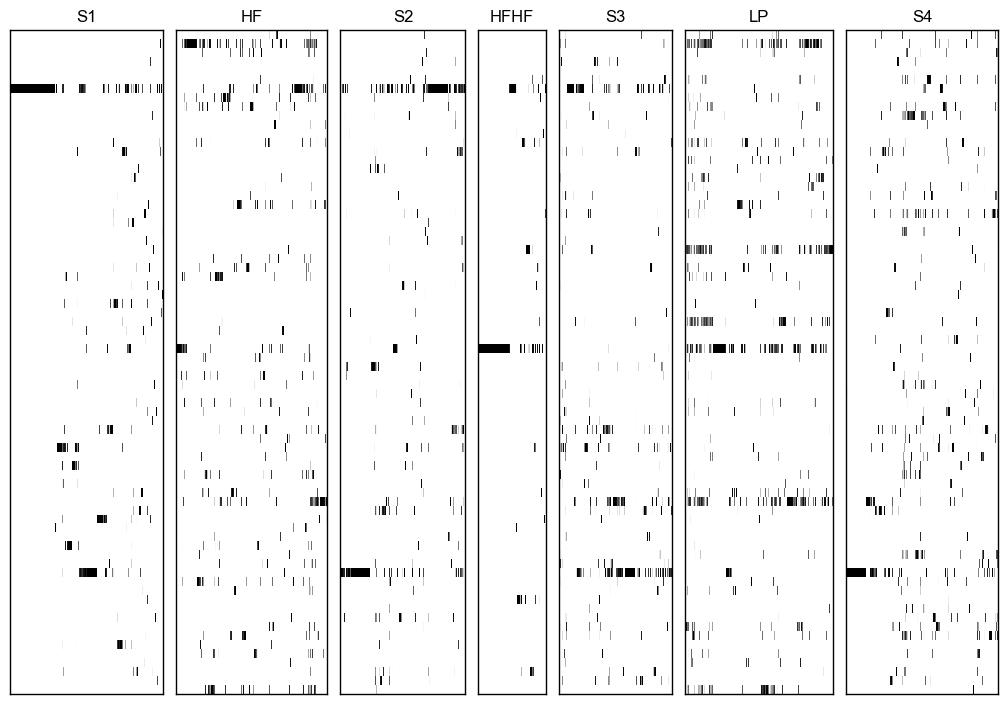

In [82]:
scale = 1.5
fig = plt.figure(figsize=(8.5*scale,11.5*scale*0.5))
gs = fig.add_gridspec(nrows=1, ncols=len(mouse_times), width_ratios=time_widths, wspace=0.1)

ord_data = {}
ax = []
for i,t in enumerate(mouse_times):
    ax.append(fig.add_subplot(gs[i]))
    counts = mouse_pooled[t]
    ra = counts/(counts.sum(axis=1,keepdims=True))
    logra = np.log10(ra + 1e-10)
    # cluster particles
    data_matrix=logra.T
    col_dist = sch.linkage(data_matrix.T, method='ward')
    col_order = sch.leaves_list(col_dist)
    ordered_data_matrix = data_matrix[:, col_order]
    ord_data[t] = ordered_data_matrix.copy()
    ax[i]=sns.heatmap(ordered_data_matrix, cmap=cmap, vmin=vmin,vmax=vmax,cbar=False,ax=ax[i], 
           xticklabels=False, yticklabels=False)
    ax[i]=add_border(ax[i])
    ax[i].set_title(diets[i])

{}

#### save data so plot quicker...

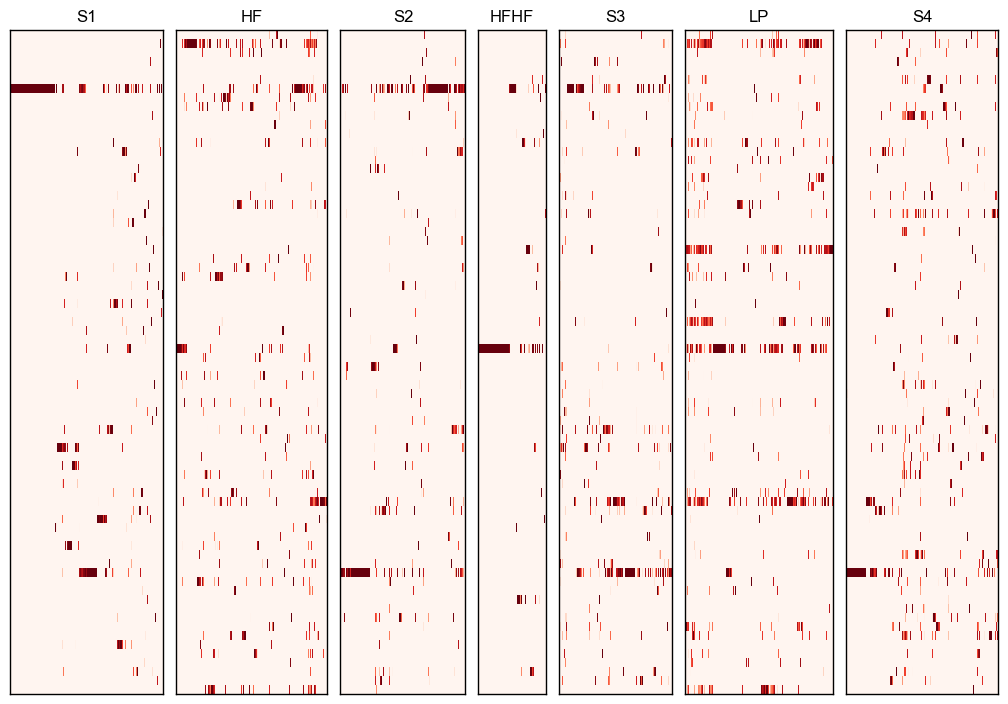

In [83]:
scale = 1.5
fig = plt.figure(figsize=(8.5*scale,11.5*scale*0.5))
gs = fig.add_gridspec(nrows=1, ncols=len(mouse_times), width_ratios=time_widths, wspace=0.1)

ax = []
for i,t in enumerate(mouse_times):
    ax.append(fig.add_subplot(gs[i]))
    ax[i]=sns.heatmap(ord_data[t], cmap='Reds', vmin=vmin,vmax=vmax,cbar=False,ax=ax[i], 
           xticklabels=False, yticklabels=False)
    ax[i]=add_border(ax[i])
    ax[i].set_title(diets[i])

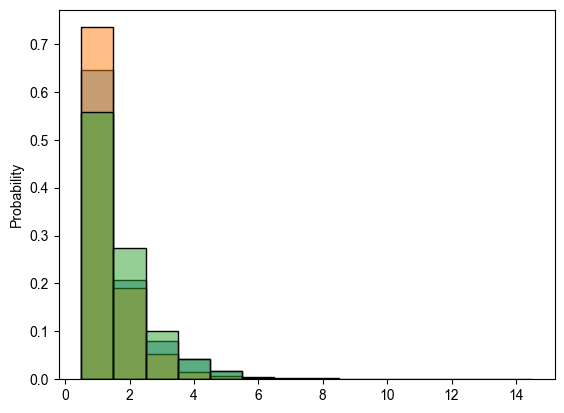

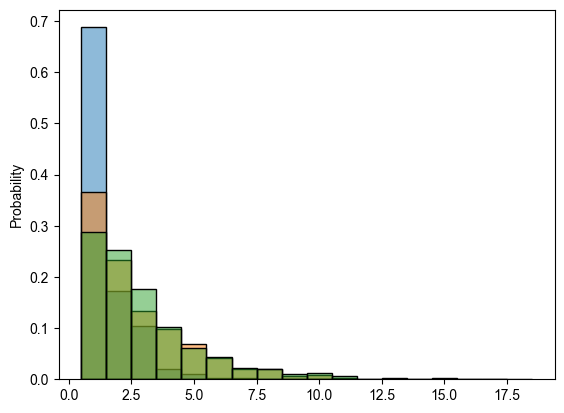

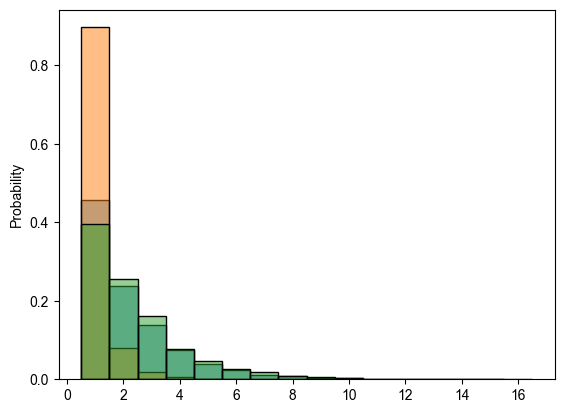

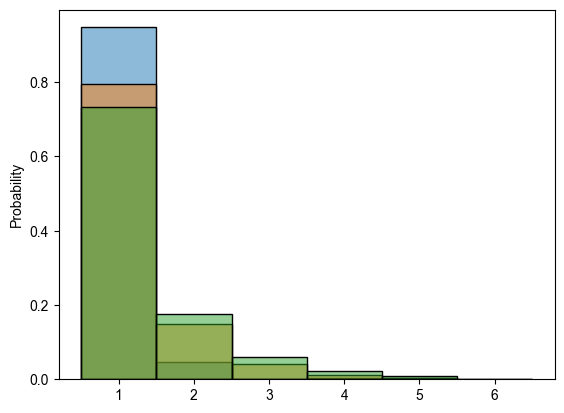

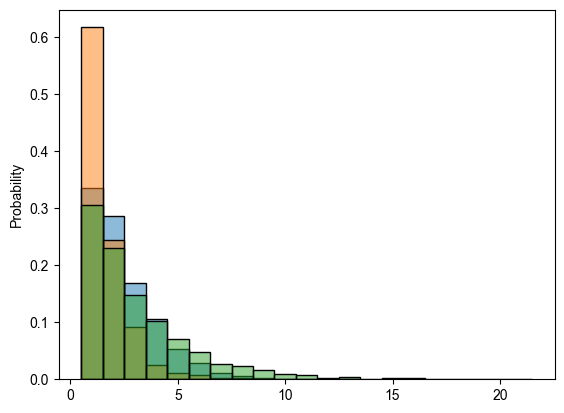

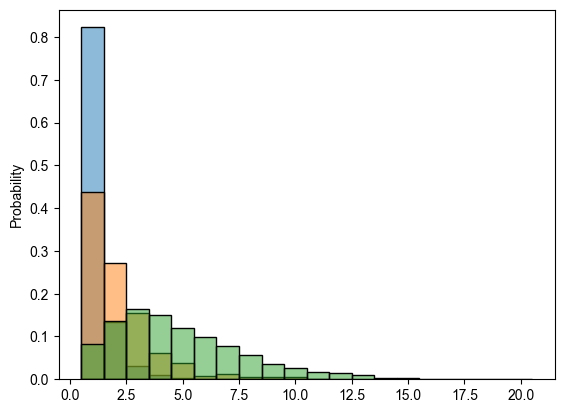

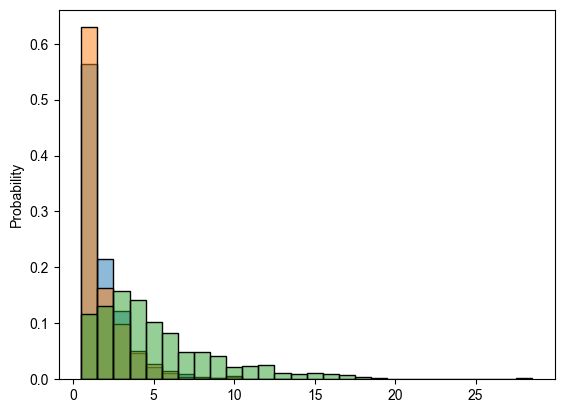

In [93]:
for t in mouse_times:
    fig, ax = plt.subplots()
    for s in mouse_subjects:
        counts = mouse_reads[t][s]
        ra = counts/(counts.sum(axis=1,keepdims=True))
        nopps = (ra>0.005).sum(axis=1)
        ax=sns.histplot(nopps, discrete=True, ax=ax, stat='probability', alpha=0.5)

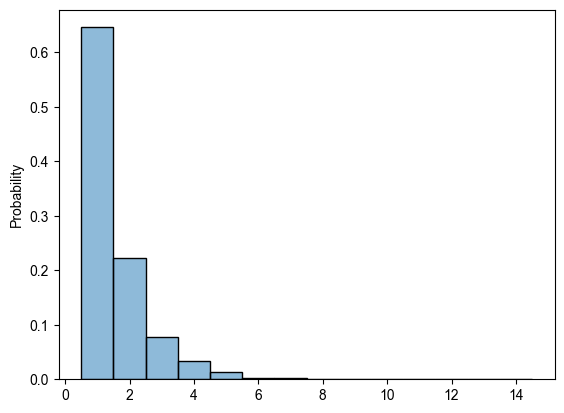

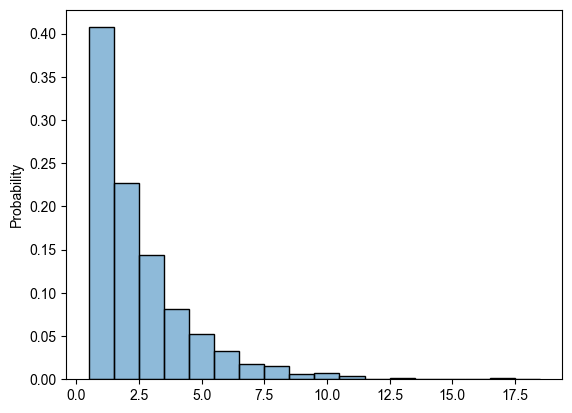

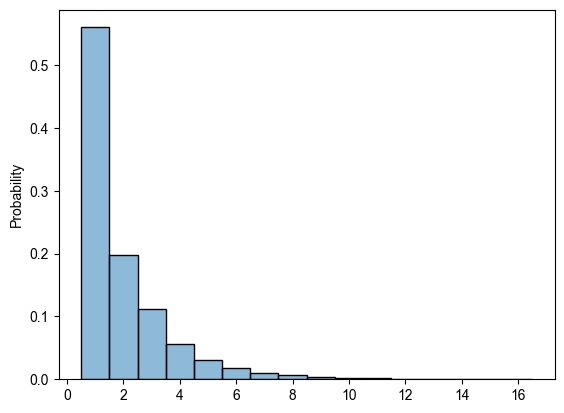

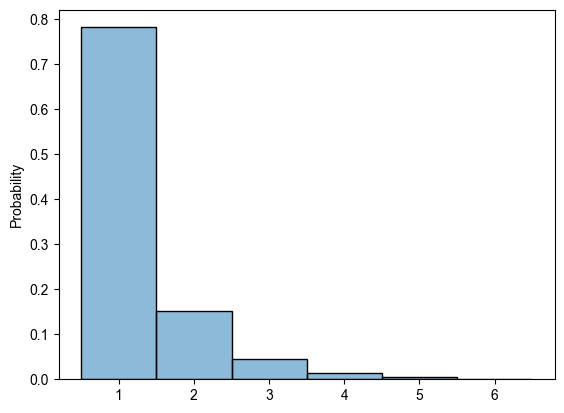

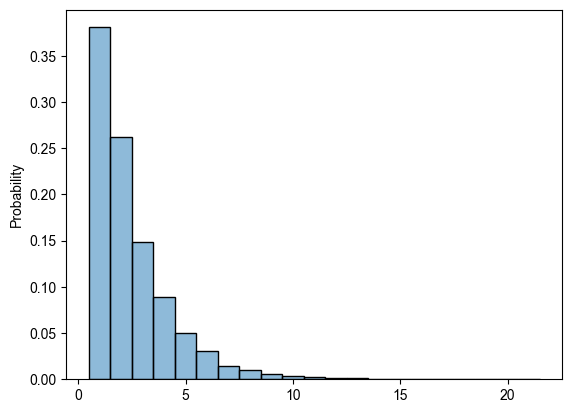

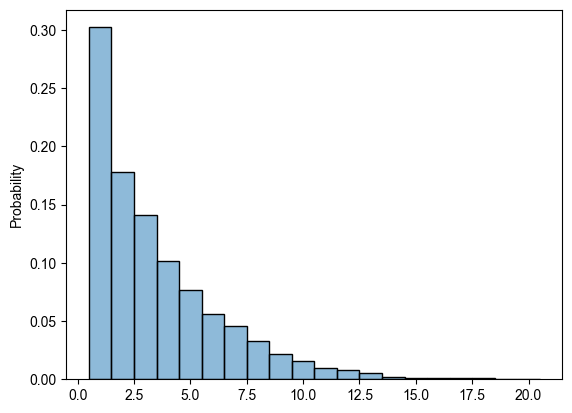

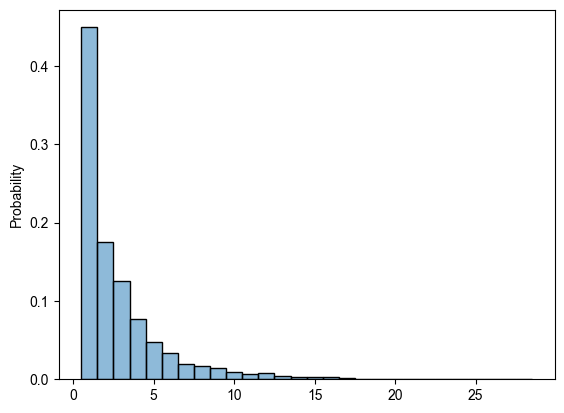

In [94]:
for t in mouse_times:
    fig, ax = plt.subplots()
    counts = mouse_pooled[t]
    ra = counts/(counts.sum(axis=1,keepdims=True))
    nopps = (ra>0.005).sum(axis=1)
    ax=sns.histplot(nopps, discrete=True, ax=ax, stat='probability', alpha=0.5)

## above, plot subj pooled distributions; maybe on top of particle distributions (though issue if resizing columns);
### or can ridge plots next to?.. 

## plot this along with entropy??

1.0
5.0


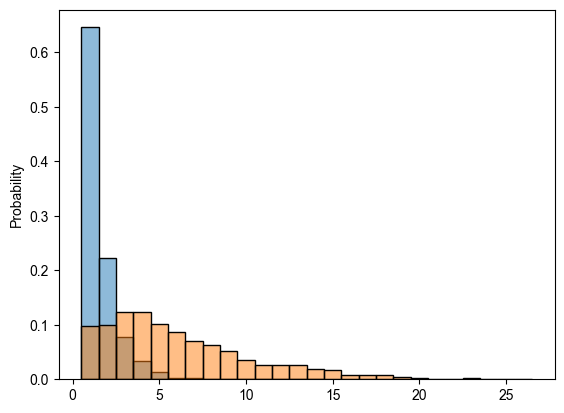

In [100]:
fig, ax = plt.subplots()
counts = mouse_pooled[mouse_times[0]]
ra = counts/(counts.sum(axis=1,keepdims=True))
nopps = (ra>0.005).sum(axis=1)
ax=sns.histplot(nopps, discrete=True, ax=ax, stat='probability', alpha=0.5)
print(np.median(nopps))

counts = humanreads[times[0]]
ra = counts/(counts.sum(axis=1,keepdims=True))
nopps = (ra>0.005).sum(axis=1)
ax=sns.histplot(nopps, discrete=True, ax=ax, stat='probability', alpha=0.5)
print(np.median(nopps))


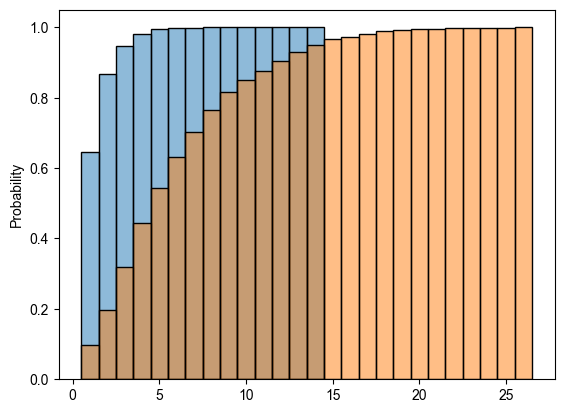

In [99]:
fig, ax = plt.subplots()
counts = mouse_pooled[mouse_times[0]]
ra = counts/(counts.sum(axis=1,keepdims=True))
nopps = (ra>0.005).sum(axis=1)
ax=sns.histplot(nopps, discrete=True, ax=ax, stat='probability', alpha=0.5, cumulative=True)

counts = humanreads[times[0]]
ra = counts/(counts.sum(axis=1,keepdims=True))
nopps = (ra>0.005).sum(axis=1)
ax=sns.histplot(nopps, discrete=True, ax=ax, stat='probability', alpha=0.5, cumulative=True)

In [86]:
ra.shape

(2971, 74)

In [75]:
ra.sum(axis=1).shape

(9511,)

## what to plot; how to plot; for number otus per particle - how to compare mouse and human? (compare at just first timepoint?)

# old

In [63]:
time_widths = []
for t in mouse_times:
    time_widths.append(mouse_pooled[t].shape[0]/9500)

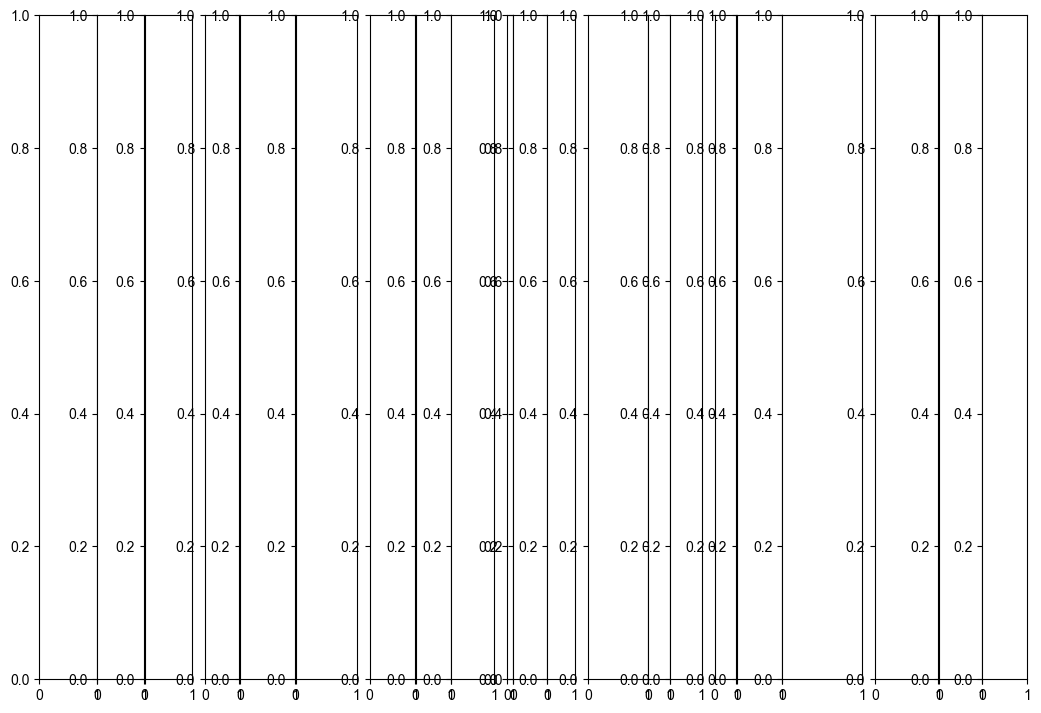

In [67]:
scale = 1.5
fig = plt.figure(figsize=(8.5*scale,11.5*scale*0.5))
gs = fig.add_gridspec(nrows=1, ncols=len(mouse_times), width_ratios=time_widths, wspace=0.1)

ax = []
for i,t in enumerate(mouse_times):
    subj_widths = []
    for s in mouse_subjects:
        subj_widths.append(mouse_reads[t][s].shape[0]/3000)
    gs_sub = gs[0,i].subgridspec(1,3, width_ratios=subj_widths, wspace=0.01)
    for j,_ in enumerate(mouse_subjects):
        ax.append(fig.add_subplot(gs_sub[0,j]))



### plot 3 rows; for each subject? [as another figure?]

In [39]:
# fig, ax = plt.subplots(figsize=(8,5),ncols=len(times)+2, nrows=2, height_ratios=[1,5], width_ratios=width_ratios)
# tree_fontsize = 4

# ax_tree = ax[1,0]
# # plot tree
# taxa = taxonomy.reset_index().copy()
# taxa = taxa.set_index("Otu")
# taxa_subset = taxa #.loc[otu_sub_z2,:]
# tree = get_pruned_tree(treepath, treefile, taxa_subset, temppath=Path("./_tmp_sub"), upper=True)
# ax_tree, otu_order = plot_phylo_tree(ax_tree, tree, taxonomy, fontsize=tree_fontsize) #, text_len=tree_text_len)

# for ix,t in enumerate(times):
#     i = ix+2
#     counts = humanreads[t]
#     ra = counts/(counts.sum(axis=1,keepdims=True))
#     notuspp = (ra>0.005).sum(axis=1)

#     logra = np.log10(ra + 1e-10)
#     # cluster particles
#     data_matrix=logra.T
#     col_dist = sch.linkage(data_matrix.T, method='ward')
#     col_order = sch.leaves_list(col_dist)
#     ordered_data_matrix = data_matrix[:, col_order]

#     ax[0,i]=sns.histplot(notuspp, discrete=True, ax=ax[0,i], stat='probability')
#     ax[1,i]=sns.heatmap(ordered_data_matrix, cmap=cmap, vmin=vmin,vmax=vmax,cbar=False,ax=ax[1,i], 
#                    xticklabels=False, yticklabels=True)
#     # ax.set_xticklabels("")
#     ax[1,i].set_yticklabels("")
#     ax[1,i]=add_border(ax[1,i])



# ax[0,0] = remove_border(ax[0,0])
# ax[0,1] = remove_border(ax[0,1])
# ax[1,1]=remove_border(ax[1,1])

# old

In [64]:
# taxonomy

In [59]:
taxonomy.shape

(58, 7)

### plot otus per particle... for each sample?

In [25]:
# create the data
timepoint = []
nopps = []
for t in times:
    counts = humanreads[t]
    # get otus per particle
    ra = counts/(counts.sum(axis=1,keepdims=True))
    notuspp = (ra>0.005).sum(axis=1)
    for v in notuspp:
        timepoint.append(t)
        nopps.append(v)
df = pd.DataFrame({'Time': timepoint, 'Number OTUs per particle': nopps})

C:\Users\Gary\anaconda3\envs\mcfinal\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Gary\anaconda3\envs\mcfinal\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Gary\anaconda3\envs\mcfinal\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)


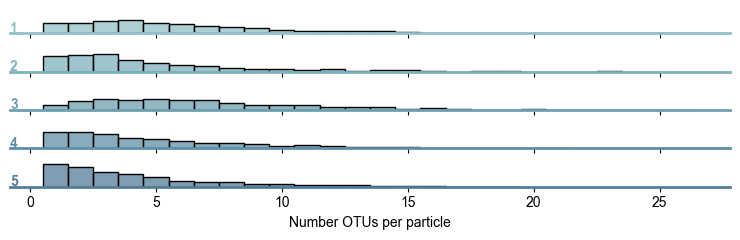

In [29]:
# initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="Time", hue="Time", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
# g.map(sns.distplot, "Number OTUs per particle",
#       bw_adjust=.5, clip_on=False,
#       fill=True, alpha=1, linewidth=1.5)
g.map(sns.histplot, "Number OTUs per particle", discrete=True, stat='probability')
#       , clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "Number OTUs per particle")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
plt.tight_layout()

In [114]:

# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m

In [115]:
df

,x,g
0,64.038123,A
1,66.147050,B
2,66.370011,C
3,68.791019,D
4,70.583534,E
...,...,...
495,69.358022,F
496,72.212877,G
497,70.474247,H
498,73.251022,I


### divide each block in mouse into subjects (concatentated, but split by line)